In [1]:
import cv2
import kornia
import numpy as np
import torch
import torchvision.transforms as T
import gym
from torch import nn
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image, to_tensor

from pytorch_msssim import ssim


class RandomShiftsAug(nn.Module):
    def __init__(self, pad):
        super().__init__()
        self.pad = pad

    def forward(self, x):
        n, c, h, w = x.size()
        assert h == w
        padding = tuple([self.pad] * 4)
        x = F.pad(x, padding, 'replicate')
        eps = 1.0 / (h + 2 * self.pad)
        arange = torch.linspace(-1.0 + eps,
                                1.0 - eps,
                                h + 2 * self.pad,
                                device=x.device,
                                dtype=x.dtype)[:h]
        arange = arange.unsqueeze(0).repeat(h, 1).unsqueeze(2)
        base_grid = torch.cat([arange, arange.transpose(1, 0)], dim=2)
        base_grid = base_grid.unsqueeze(0).repeat(n, 1, 1, 1)

        shift = torch.randint(0,
                              2 * self.pad + 1,
                              size=(n, 1, 1, 2),
                              device=x.device,
                              dtype=x.dtype)
        shift *= 2.0 / (h + 2 * self.pad)

        grid = base_grid + shift
        return F.grid_sample(x,
                             grid,
                             padding_mode='zeros',
                             align_corners=False)

/usr/local/lib/python3.9/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
def kl_divergence(mu1, sigma1, mu2, sigma2):
    return torch.log(sigma2 / sigma1) + (sigma1 ** 2 + (mu1 - mu2) ** 2) / (2 * sigma2 ** 2) - 0.5


def bhattacharyya_distance(mu1, sigma1, mu2, sigma2):
    return 0.25 * torch.log(0.25 * (sigma1 ** 2 / sigma2 ** 2 + sigma2 ** 2 / sigma1 ** 2 + 2)) + 0.25 * (
                (mu1 - mu2) ** 2 / (sigma1 ** 2 + sigma2 ** 2))


def wasserstein_distance(mu1, sigma1, mu2, sigma2):
    return torch.sqrt((mu1 - mu2)**2 + (sigma1 - sigma2)**2)

In [3]:
def img_info_pre_and_post_augment(obs_tensor, obs_augmented_tensor, print_stats = False, shape=(3, 480, 480)):
    # Assuming obs_augmented_tensor is of shape [N, C, H, W]
    mu1 = obs_tensor.mean(dim=[2, 3])  # Compute mean across height and width for each channel in each image
    sigma1 = obs_tensor.std(dim=[2, 3])  # Compute std across height and width for each channel in each image
    if print_stats:
        print("Mean per image - pre augment:: ", mu1)
        print("Std per image - pre augment:: ", sigma1)
        print('obs tensor shape - pre augment:: ', obs_tensor.shape)

    # Flatten the image to a 1D array
    encoded_img_array = obs_tensor.flatten()
    # encoded_img_array is now a 1D array of shape [3*480*480]
    if print_stats:
        print(encoded_img_array.shape)
    # Reshape the 1D array back to its original shape
    decoded_img_array = encoded_img_array.reshape(shape[0], shape[1], shape[2])
    # decoded_img_array now has the original shape of [3, 480, 480]
    if print_stats:
        print(decoded_img_array.shape)
    # Apply the augmentation
    # Remove batch dimension and convert back to PIL image for saving
    obs_augmented_image = to_pil_image(obs_augmented_tensor.squeeze(0))
    # Assuming obs_augmented_tensor is of shape [N, C, H, W]
    # is it at pixel level or???
    mu2 = obs_augmented_tensor.mean(dim=[2, 3])  # Compute mean across height and width for each channel in each image
    sigma2 = obs_augmented_tensor.std(dim=[2, 3])  # Compute std across height and width for each channel in each image
    if print_stats:
        print("Mean per image - post augment:: ", mu2)
        print("Std per image - post augment:: ", sigma2)
        print('obs tensor shape - pot augment:: ', obs_augmented_tensor.shape)
    # Save the augmented observation image
    obs_augmented_image.save("augmented_observation_drqv2.png")
    return mu1, sigma1, mu2, sigma2

In [4]:
def augment_obs(obs, pad=4):
    augment = RandomShiftsAug(pad=pad)
    obs_copy = obs.copy()
    obs_tensor = to_tensor(obs_copy).unsqueeze(0)

    with torch.no_grad():  # No need to track gradients
        obs_augmented_tensor = augment(obs_tensor)

    return obs_tensor, obs_augmented_tensor

In [5]:
env_name = "HalfCheetah-v4"
env = gym.make(env_name, render_mode='rgb_array')

state, done, truncated = env.reset(), False, False
obs = env.render()  # Get an RGB image of the environment
print(obs.shape, type(obs))
cv2.imwrite("original_observation_drqv2.png", cv2.cvtColor(obs, cv2.COLOR_RGB2BGR))

(480, 480, 3) <class 'numpy.ndarray'>


2024-04-21 15:23:31.652 Python[5696:6819455] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/dy/5pnjrk157kx1rssgt1jsh7w40000gn/T/org.python.python.savedState


True

In [6]:
for i in range(10):
    pad = i  # Example padding value
    print("Using padding {}".format(pad))
    # Initialize the augmentation module
    obs_tensor, obs_augmented_tensor = augment_obs(obs, pad=pad)
    mu1, sigma1, mu2, sigma2 = img_info_pre_and_post_augment(obs_tensor, obs_augmented_tensor)

    kl_div = kl_divergence(mu1, sigma1, mu2, sigma2)
    print("KL Divergence:", kl_div)

    bd = bhattacharyya_distance(mu1, sigma1, mu2, sigma2)
    print("Bhattacharyya Distance:", bd)

    wd = wasserstein_distance(mu1, sigma1, mu2, sigma2)
    print("Wasserstein Distance:", wd)
    ssim_val = ssim(obs_tensor, obs_augmented_tensor, data_range=1.0, size_average=True)  # Assuming images are scaled [0, 1]
    print("SSIM:", ssim_val.item())

Using padding 0
KL Divergence: tensor([[0.0000e+00, 5.9605e-08, 0.0000e+00]])
Bhattacharyya Distance: tensor([[0., 0., 0.]])
Wasserstein Distance: tensor([[1.0431e-07, 1.1921e-07, 8.9407e-08]])
SSIM: 0.9999998211860657
Using padding 1
KL Divergence: tensor([[1.7881e-07, 1.7881e-07, 1.7881e-07]])
Bhattacharyya Distance: tensor([[2.3160e-08, 2.6327e-08, 2.3048e-08]])
Wasserstein Distance: tensor([[0.0001, 0.0001, 0.0001]])
SSIM: 0.9840488433837891
Using padding 2
KL Divergence: tensor([[4.6492e-06, 5.1856e-06, 4.3511e-06]])
Bhattacharyya Distance: tensor([[1.1617e-06, 1.2845e-06, 1.1190e-06]])
Wasserstein Distance: tensor([[0.0006, 0.0006, 0.0006]])
SSIM: 0.8295444846153259
Using padding 3
KL Divergence: tensor([[1.3590e-05, 1.3053e-05, 1.2994e-05]])
Bhattacharyya Distance: tensor([[3.3793e-06, 3.2550e-06, 3.2290e-06]])
Wasserstein Distance: tensor([[0.0011, 0.0011, 0.0011]])
SSIM: 0.8017577528953552
Using padding 4
KL Divergence: tensor([[1.0115e-04, 1.0520e-04, 9.6798e-05]])
Bhattachar

Using padding 0
KL Divergence: tensor([[0.0000e+00, 5.9605e-08, 0.0000e+00]])
Using padding 1
KL Divergence: tensor([[0.0000e+00, 5.9605e-08, 0.0000e+00]])
Using padding 2
KL Divergence: tensor([[2.1756e-05, 2.3305e-05, 2.0802e-05]])
Using padding 3
KL Divergence: tensor([[2.6226e-05, 2.7418e-05, 2.5094e-05]])
Using padding 4
KL Divergence: tensor([[2.9683e-05, 3.0339e-05, 2.8431e-05]])
Using padding 5
KL Divergence: tensor([[2.6226e-05, 2.7418e-05, 2.5034e-05]])
Using padding 6
KL Divergence: tensor([[5.8532e-05, 6.8069e-05, 5.6088e-05]])
Using padding 7
KL Divergence: tensor([[0.0004, 0.0004, 0.0004]])
Using padding 8
KL Divergence: tensor([[9.5308e-05, 9.3818e-05, 9.0599e-05]])
Using padding 9
KL Divergence: tensor([[0.0003, 0.0003, 0.0003]])
[tensor([0.0000e+00, 5.9605e-08, 0.0000e+00]), tensor([0.0000e+00, 5.9605e-08, 0.0000e+00]), tensor([2.1756e-05, 2.3305e-05, 2.0802e-05]), tensor([2.6226e-05, 2.7418e-05, 2.5094e-05]), tensor([2.9683e-05, 3.0339e-05, 2.8431e-05]), tensor([2.622

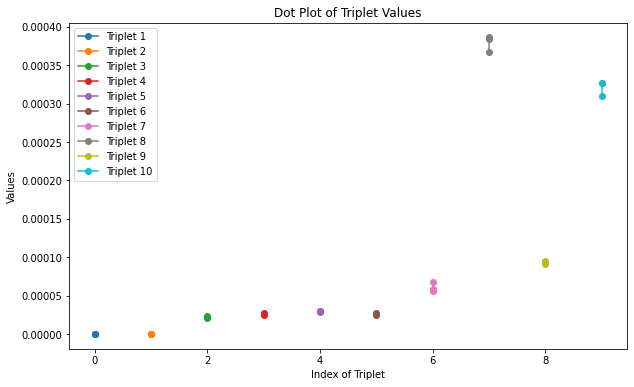

In [7]:
kl_metrics_per_channel = []
for i in range(10):
    pad = i  # Example padding value
    print("Using padding {}".format(pad))
    # Initialize the augmentation module
    obs_tensor, obs_augmented_tensor = augment_obs(obs, pad=pad)
    mu1, sigma1, mu2, sigma2 = img_info_pre_and_post_augment(obs_tensor, obs_augmented_tensor)

    kl_div = kl_divergence(mu1, sigma1, mu2, sigma2)
    kl_metrics_per_channel.append(kl_div[0])
    print("KL Divergence:", kl_div)

print(kl_metrics_per_channel)

import matplotlib.pyplot as plt
import torch

# Create a plot
plt.figure(figsize=(10, 6))

# Each triplet should be plotted with a different color
for index, triplet in enumerate(kl_metrics_per_channel):
    # Extract x, y, z components
    x = [index] * 3
    y = triplet.numpy()
    plt.plot(x, y, 'o-', label=f'Triplet {index+1}')

# Setting up the plot
plt.xlabel('Index of Triplet')
plt.ylabel('Values')
plt.title('Dot Plot of Triplet Values')
plt.legend()
plt.show()


In [37]:
import cv2
import matplotlib.pyplot as plt

def load_and_display_images(original_image_path, augmented_image_path):
    # Load the original and augmented images
    original_image = cv2.imread(original_image_path)
    augmented_image = cv2.imread(augmented_image_path)

    # Convert images from BGR to RGB format
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)

    # Display the images using Matplotlib
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    plt.title('Augmented Image')
    plt.axis('off')

    plt.show()

# Example usage:
# load_and_display_images("original_observation_drqv2.png", "augmented_observation_drqv2.png")

import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_triplets_and_stats(kl_metrics_per_channel_per_pad):
    # Create a plot for dot plot
    plt.figure(figsize=(10, 6))
    for index, triplet in enumerate(kl_metrics_per_channel_per_pad):
        x = [index] * 3
        y = triplet.numpy()
        plt.plot(x, y, 'o-', label=f'Triplet {index+1}')

    plt.xlabel('Index of Triplet')
    plt.ylabel('Values')
    plt.title('Dot Plot of Triplet Values')
    plt.show()

    # Create a plot for bar plot
    plt.figure(figsize=(10, 6))
    for index, triplet in enumerate(kl_metrics_per_channel_per_pad):
        plt.bar([index*3, index*3+1, index*3+2], triplet.numpy(), label=f'Triplet {index+1}')

    plt.xlabel('Index of Value')
    plt.ylabel('Values')
    plt.title('Bar Plot of Triplet Values')
    plt.show()

    # Create a plot for scatter plot
    plt.figure(figsize=(10, 6))
    for index, triplet in enumerate(kl_metrics_per_channel_per_pad):
        x = [index] * 3
        y = triplet.numpy()
        plt.scatter(x, y, alpha=0.6, label=f'Triplet {index+1}')

    plt.xlabel('Index of Triplet')
    plt.ylabel('Values')
    plt.title('Scatter Plot of Triplet Values')
    plt.show()




import matplotlib.pyplot as plt
import numpy as np
import torch

def scatter_hist_plotter(x, y, xlabel):
    def scatter_hist(x, y, ax, ax_histx, ax_histy):
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)

        ax.scatter(x, y)

        binwidth = 0.0001
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax / binwidth) + 1) * binwidth

        bins = np.arange(-lim, lim + binwidth, binwidth)
        ax_histx.hist(x, bins=bins)
        ax_histy.hist(y, bins=bins, orientation='horizontal')

    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)

    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

    scatter_hist(x, y, ax, ax_histx, ax_histy)
    ax.set_xlabel(f"\nScatter Plot with Marginal Distribution Historgram - {xlabel}")
    plt.show()
    
    
def calculate_statistics(kl_metrics_per_channel_per_pad):
    all_values = torch.cat(kl_metrics_per_channel_per_pad)
    mean = torch.mean(all_values).item()
    variance = torch.var(all_values).item()
    std_dev = torch.std(all_values).item()

    print(f'Mean: {mean:.30f}')
    print(f'Variance: {variance:.30f}')
    print(f'Standard Deviation: {std_dev:.30f}')
    return mean, variance, std_dev

# Example usage:
# calculate_statistics(kl_metrics_per_channel_per_pad)


In [38]:
def collect_kl_metrics(env, max_timesteps, pad):
    kl_metrics_per_channel_per_pad = []

    # Initial reset
    state, done, truncated = env.reset(), False, False
    obs = env.render()
    obs_tensor, obs_augmented_tensor = augment_obs(obs, pad=pad)
    mu1, sigma1, mu2, sigma2 = img_info_pre_and_post_augment(obs_tensor, obs_augmented_tensor)
    kl_div = kl_divergence(mu1, sigma1, mu2, sigma2)
    kl_metrics_per_channel_per_pad.append(kl_div[0])
    print("KL Divergence: reset ", kl_div)

    for t in range(max_timesteps):
        action = env.action_space.sample()
        next_state, reward, done, truncated, _ = env.step(action)
        obs = env.render()
        obs_tensor, obs_augmented_tensor = augment_obs(obs, pad=pad)
        mu1, sigma1, mu2, sigma2 = img_info_pre_and_post_augment(obs_tensor, obs_augmented_tensor)
        kl_div = kl_divergence(mu1, sigma1, mu2, sigma2)
        kl_metrics_per_channel_per_pad.append(kl_div[0])

    return kl_metrics_per_channel_per_pad

# Example usage:
# kl_metrics = collect_kl_metrics(env, max_timesteps, pad)


def collect_kl_metrics_same_image(obs, max_timesteps, pad, shape=(3, 5, 5)):
    kl_metrics_per_channel_per_pad = []

    # Initial reset
    obs_tensor, obs_augmented_tensor = augment_obs(obs, pad=pad)
    mu1, sigma1, mu2, sigma2 = img_info_pre_and_post_augment(obs_tensor, obs_augmented_tensor, shape=shape)
    kl_div = kl_divergence(mu1, sigma1, mu2, sigma2)
    kl_metrics_per_channel_per_pad.append(kl_div[0])
    print("KL Divergence: reset ", kl_div)

    for t in range(max_timesteps):
        obs_tensor, obs_augmented_tensor = augment_obs(obs, pad=pad)
        mu1, sigma1, mu2, sigma2 = img_info_pre_and_post_augment(obs_tensor, obs_augmented_tensor, shape=shape)
        kl_div = kl_divergence(mu1, sigma1, mu2, sigma2)
        kl_metrics_per_channel_per_pad.append(kl_div[0])

    return kl_metrics_per_channel_per_pad

# Example usage:
# kl_metrics = collect_kl_metrics_same_image(env, max_timesteps, pad)

Mean per image - pre augment::  tensor([[0.5067, 0.4631, 0.5213]])
Std per image - pre augment::  tensor([[0.2750, 0.3299, 0.2868]])
obs tensor shape - pre augment::  torch.Size([1, 3, 5, 5])
torch.Size([75])
torch.Size([3, 5, 5])
Mean per image - post augment::  tensor([[0.5238, 0.3995, 0.5812]])
Std per image - post augment::  tensor([[0.3013, 0.2947, 0.2578]])
obs tensor shape - pot augment::  torch.Size([1, 3, 5, 5])
padding is: 1


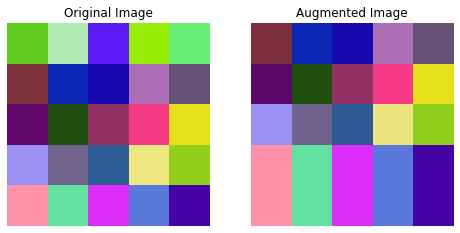

KL Divergence: reset  tensor([[0.0010, 0.0125, 0.0035]])
Mean: 0.023151887580752372741699218750
Variance: 0.000818966713268309831619262695
Standard Deviation: 0.028617594391107559204101562500


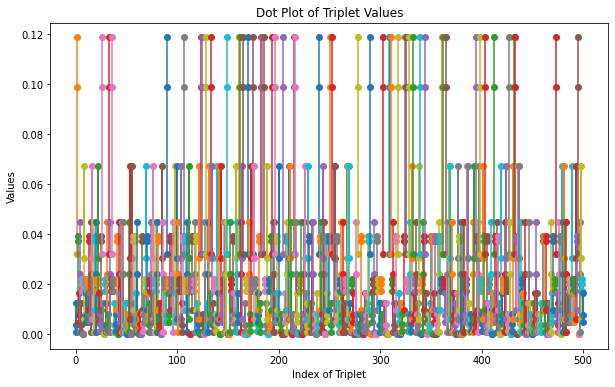

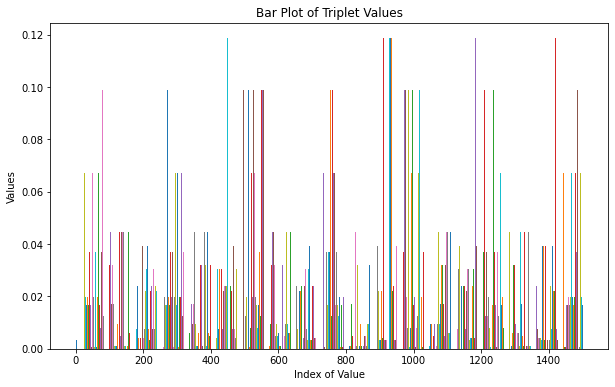

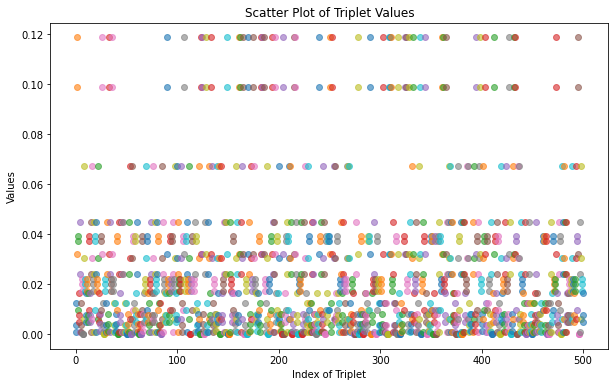

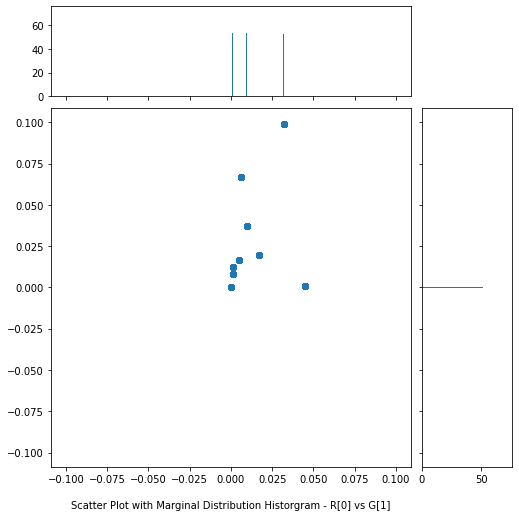

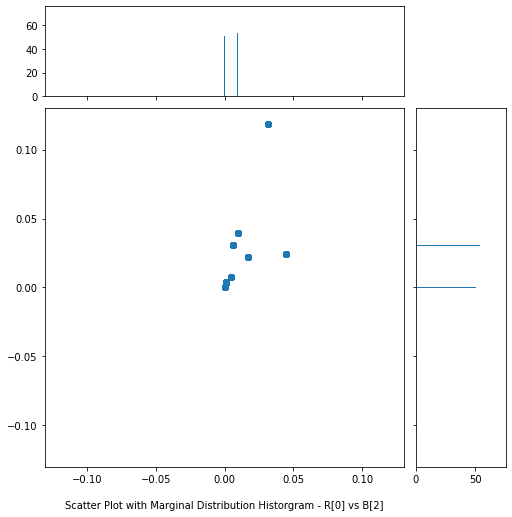

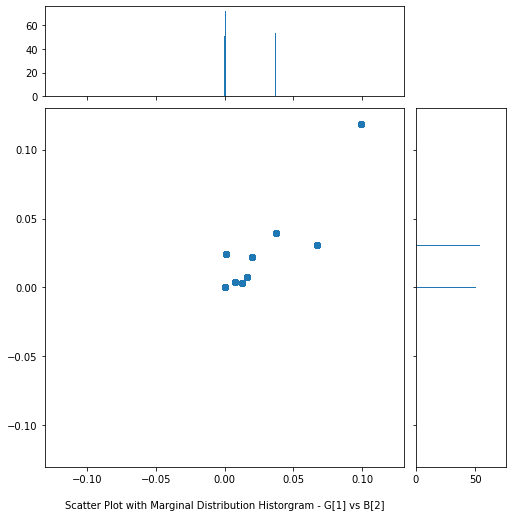

In [55]:
import torch
import numpy as np

# obs_demo = np.random.rand(5, 5, 3)
obs_demo = (np.random.rand(5, 5, 3) * 255).astype(np.uint8)
pad = 1
# Display the generated tensor
# print(obs_demo)
# obs_demo_uint8 = (obs_demo * 255).astype(np.uint8)
cv2.imwrite("original_observation_drqv2.png", cv2.cvtColor(obs_demo, cv2.COLOR_RGB2BGR))
obs_tsr, obs_augmented_tsr = augment_obs(obs_demo, pad=pad)
mu1, sigma1, mu2, sigma2 = img_info_pre_and_post_augment(obs_tsr, obs_augmented_tsr, print_stats=True, shape=(3, 5, 5))

print("padding is:", pad)
load_and_display_images("original_observation_drqv2.png", "augmented_observation_drqv2.png")

max_timesteps = 500
kl_metrics = collect_kl_metrics_same_image(obs_demo, max_timesteps, pad, shape=(3, 5, 5))
mu, var, std = calculate_statistics(kl_metrics)

# print(kl_metrics)
visualize_triplets_and_stats(kl_metrics)

# Figure setup with gridspec for scatter histogram
flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]

scatter_hist_plotter(x1, x2, "R[0] vs G[1]")
scatter_hist_plotter(x1, x3, "R[0] vs B[2]")
scatter_hist_plotter(x2, x3, "G[1] vs B[2]")

# try to access directly the actor related pixels
# what is the right augmentation? parts we can't loose
# will prepare some more transformations:
#  - background rendering(distractors)
#  - check others...

# maybe better CNNs can be used

padding is: 0
KL Divergence: reset  tensor([[0., 0., 0.]])
Mean: 0.000000008446965793496019614395
Variance: 0.000000000000000451337429598395
Standard Deviation: 0.000000021244703773959372483660


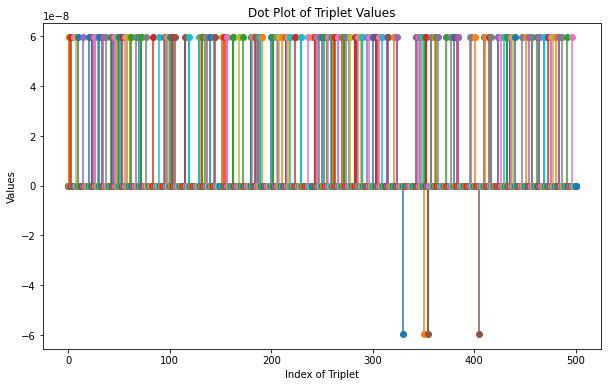

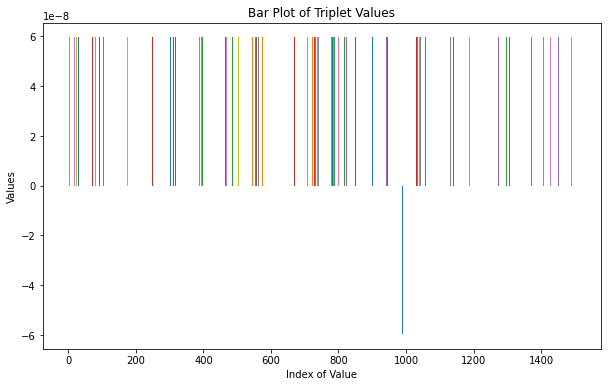

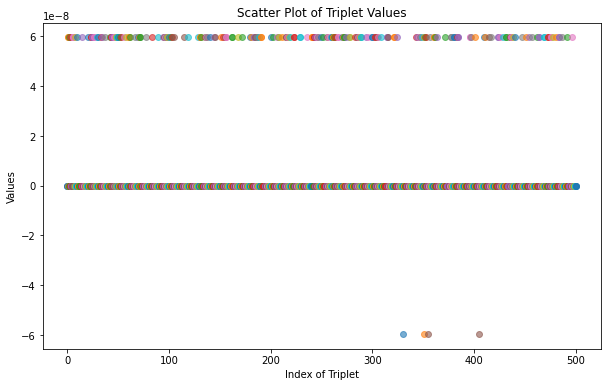

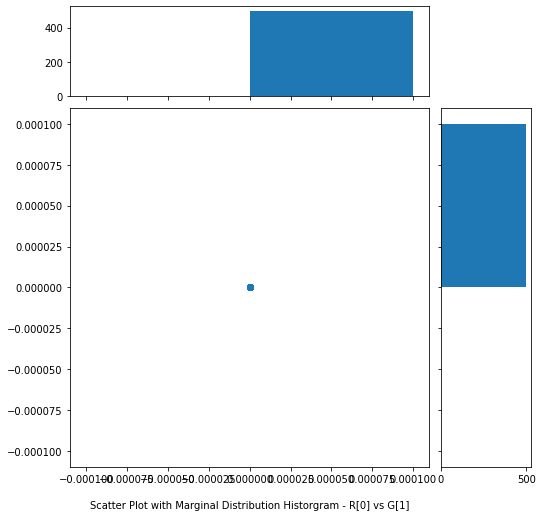

In [45]:
env_name = "HalfCheetah-v4"
env = gym.make(env_name, render_mode='rgb_array')

max_timesteps = 500
pad = 0
stats = []

print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")

padding is: 1
KL Divergence: reset  tensor([[3.4571e-06, 4.0531e-06, 3.4571e-06]])
Mean: 0.000004311382781452266499400139
Variance: 0.000000000014260552808065263264
Standard Deviation: 0.000003776314770220778882503510


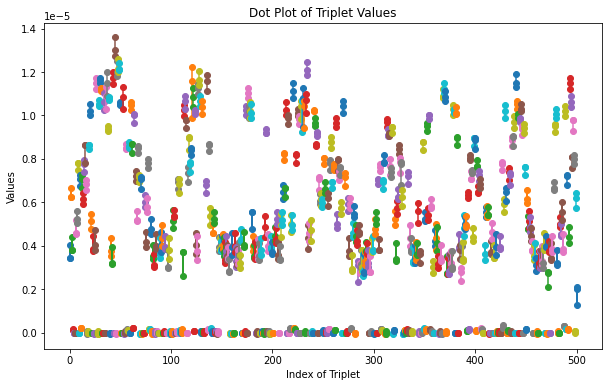

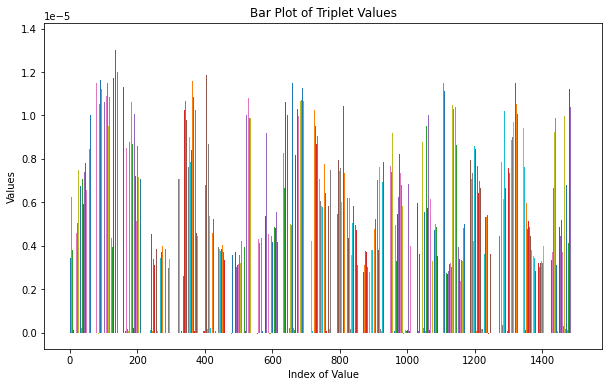

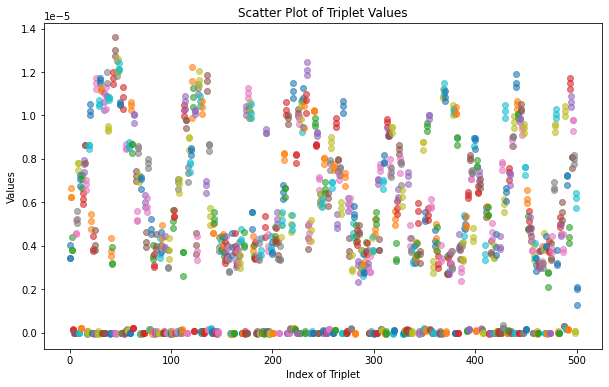

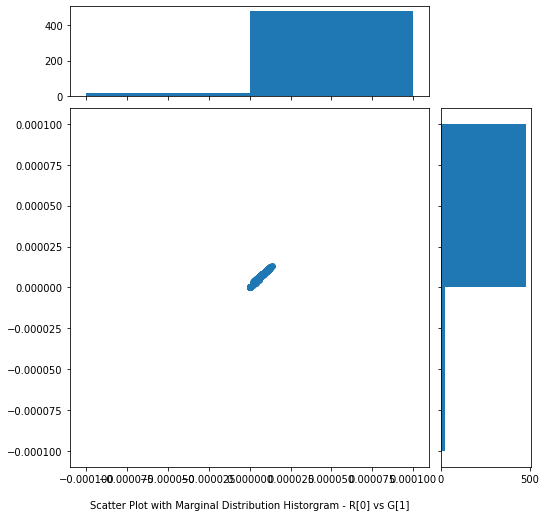

padding is: 2
KL Divergence: reset  tensor([[0., 0., 0.]])
Mean: 0.000012622463145817164331674576
Variance: 0.000000000163179747492137039444
Standard Deviation: 0.000012774183232977520674467087


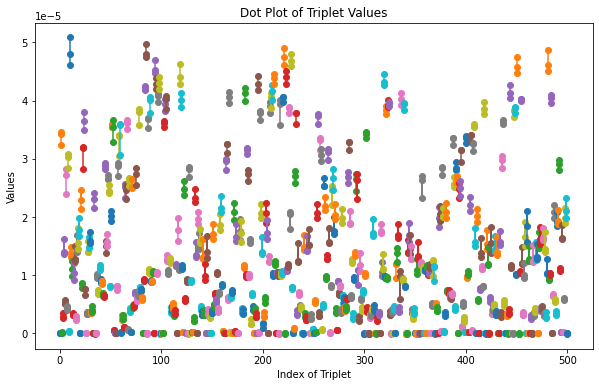

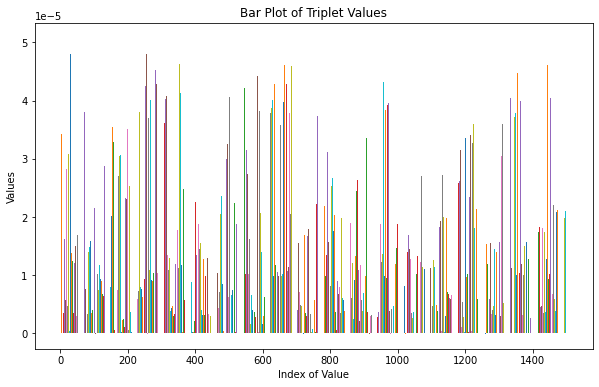

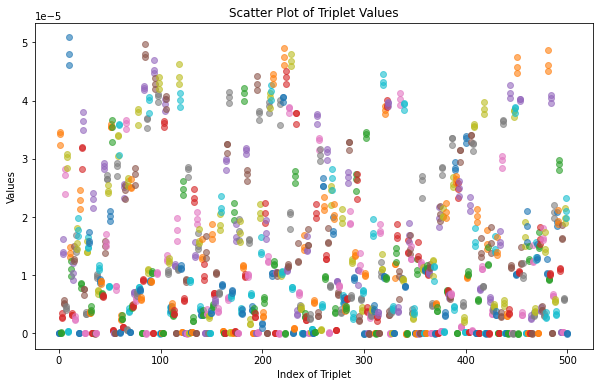

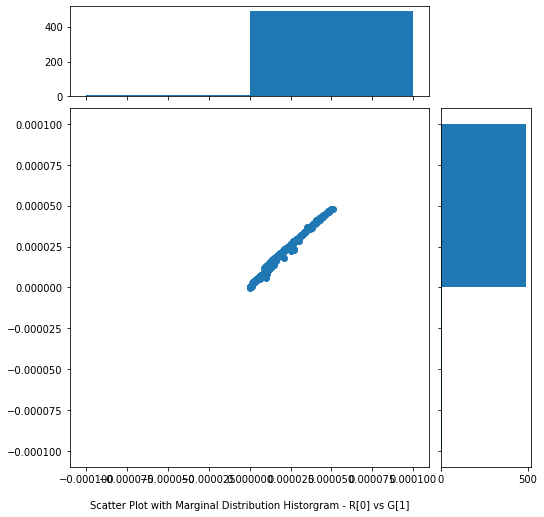

padding is: 3
KL Divergence: reset  tensor([[2.2590e-05, 2.3901e-05, 2.0981e-05]])
Mean: 0.000028834014301537536084651947
Variance: 0.000000000827380997048265953708
Standard Deviation: 0.000028764230592059902846813202


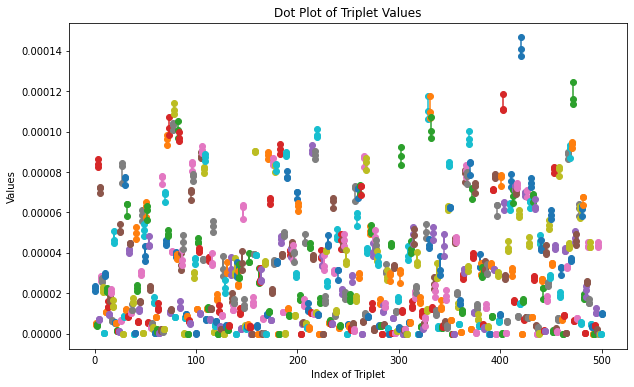

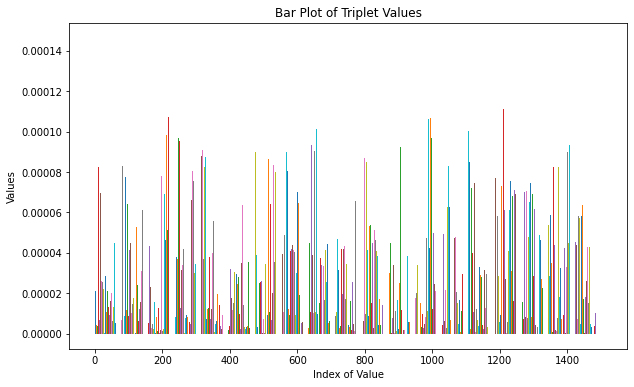

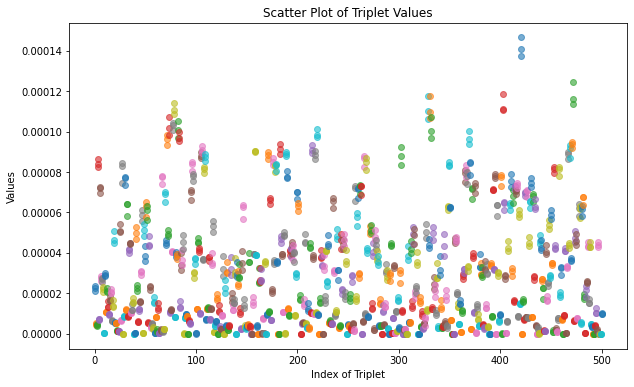

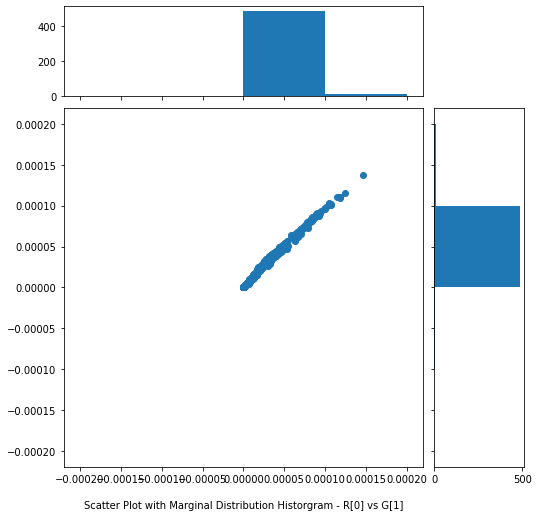

padding is: 4
KL Divergence: reset  tensor([[2.4438e-05, 2.5749e-05, 2.3425e-05]])
Mean: 0.000047368976083816960453987122
Variance: 0.000000002063821780140528971970
Standard Deviation: 0.000045429307647282257676124573


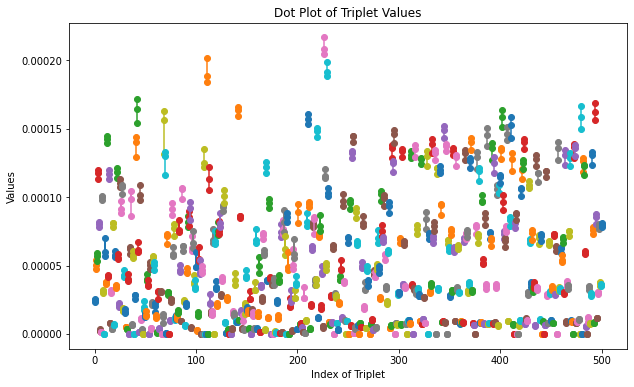

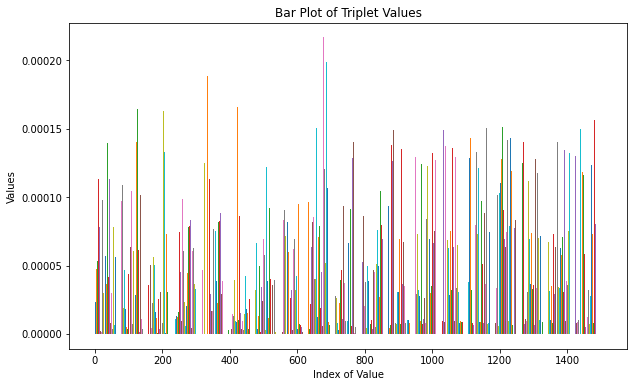

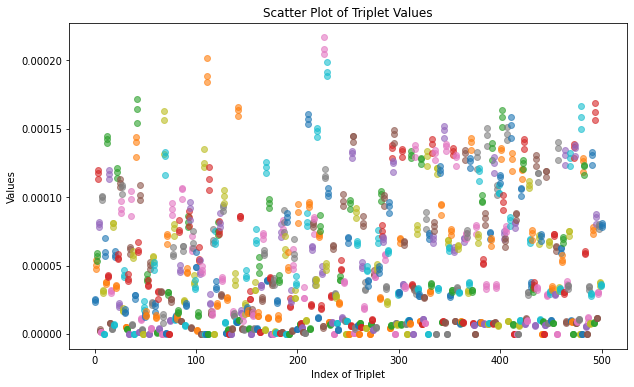

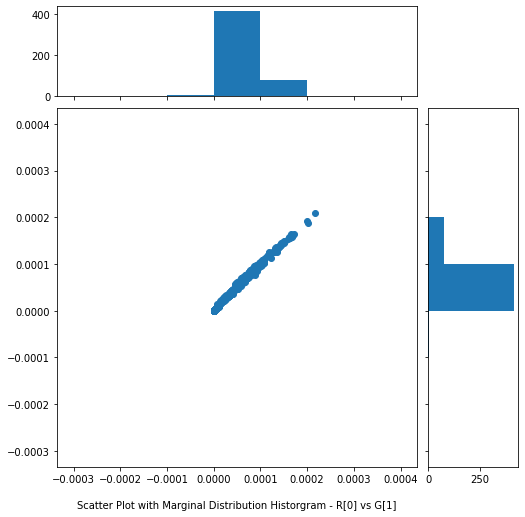

padding is: 5
KL Divergence: reset  tensor([[1.1921e-07, 1.7881e-07, 1.7881e-07]])
Mean: 0.000071574111643712967634201050
Variance: 0.000000005446806561337780294707
Standard Deviation: 0.000073802482802420854568481445


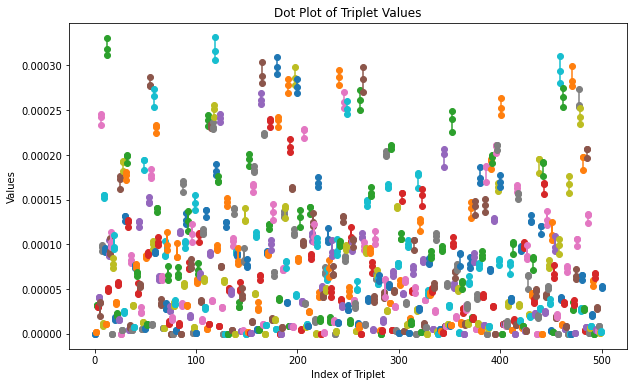

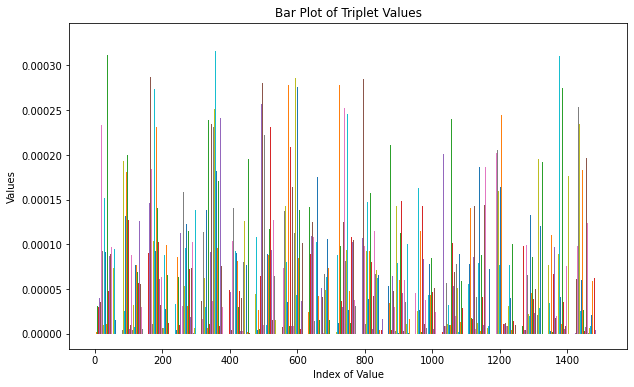

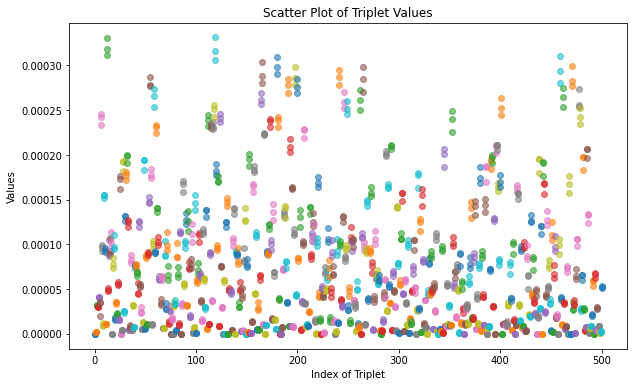

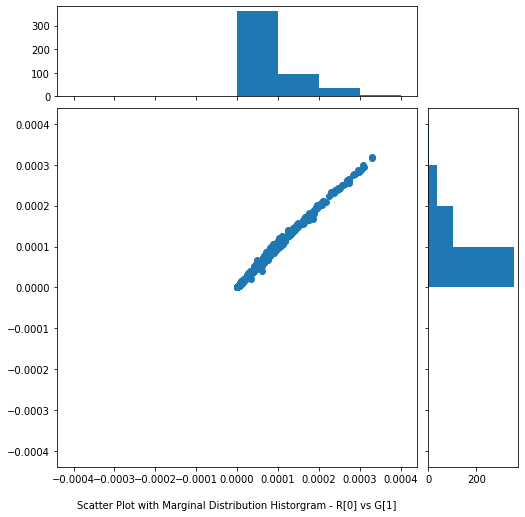

padding is: 6
KL Divergence: reset  tensor([[0.0001, 0.0002, 0.0001]])
Mean: 0.000102443984360434114933013916
Variance: 0.000000011761122742370844207471
Standard Deviation: 0.000108448708488140255212783813


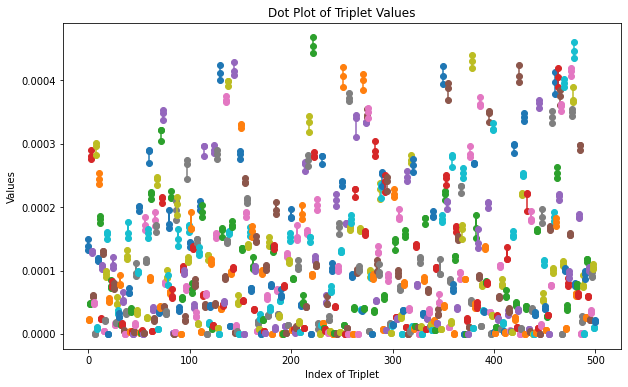

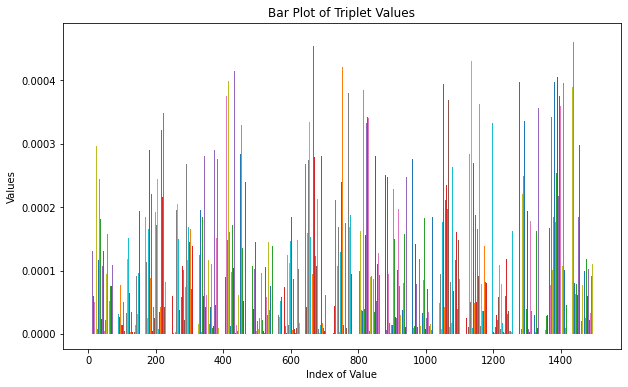

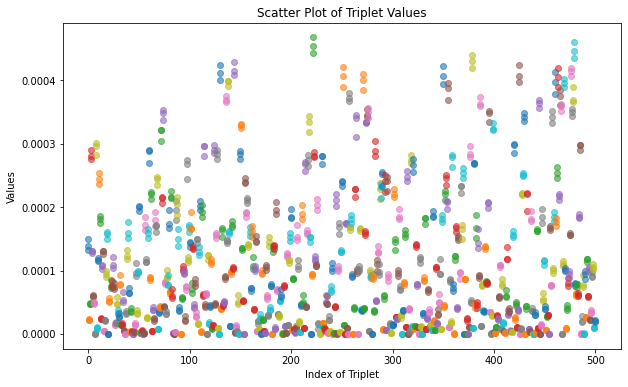

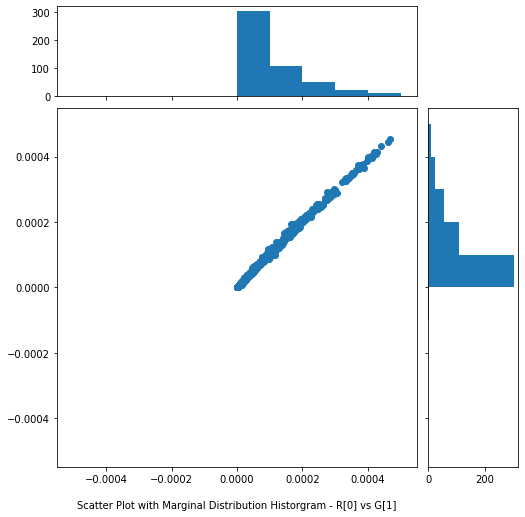

padding is: 7
KL Divergence: reset  tensor([[0.0001, 0.0001, 0.0001]])
Mean: 0.000120253047498408704996109009
Variance: 0.000000015690540422497178951744
Standard Deviation: 0.000125261882203631103038787842


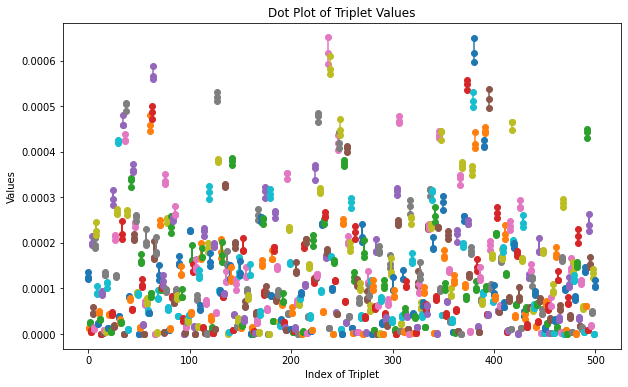

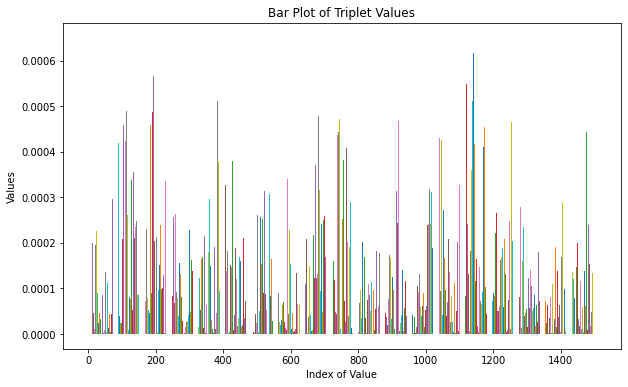

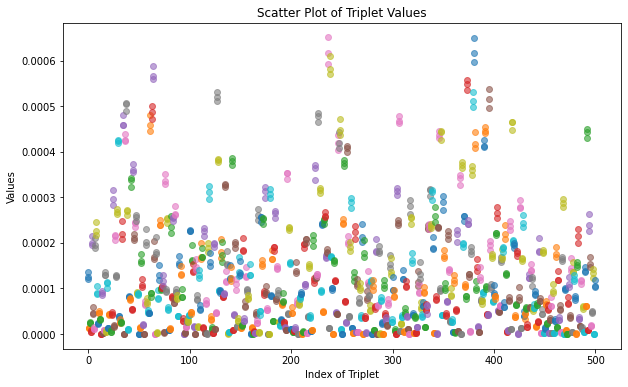

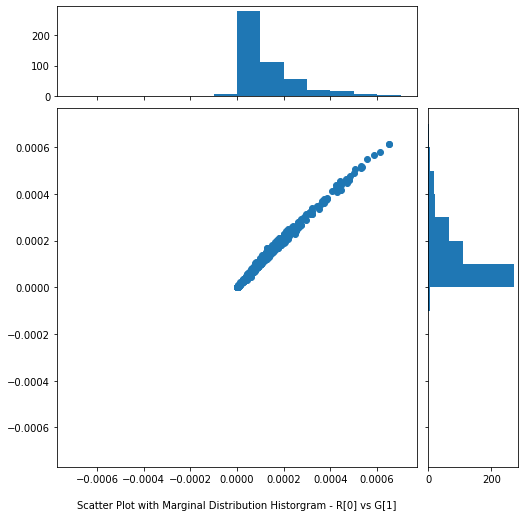

padding is: 8
KL Divergence: reset  tensor([[0.0005, 0.0005, 0.0005]])
Mean: 0.000173418491613119840621948242
Variance: 0.000000029314579208516988728661
Standard Deviation: 0.000171215011505410075187683105


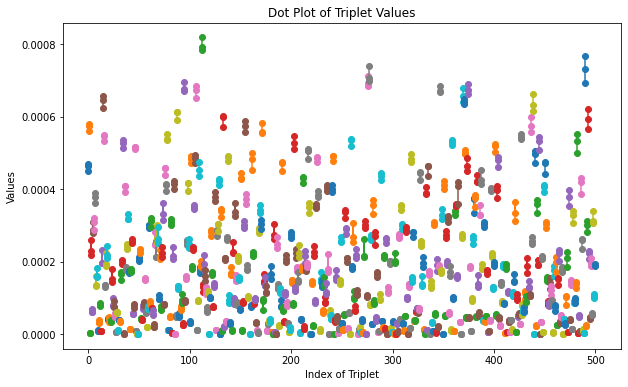

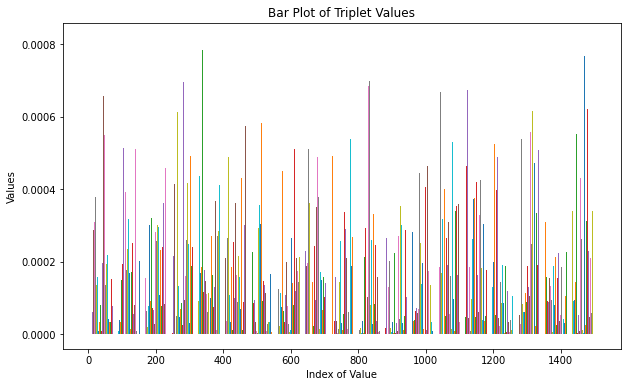

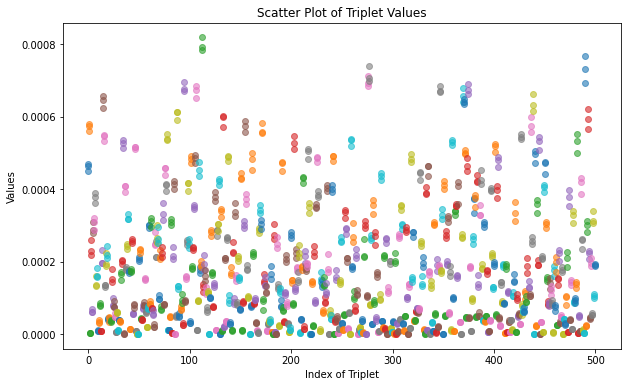

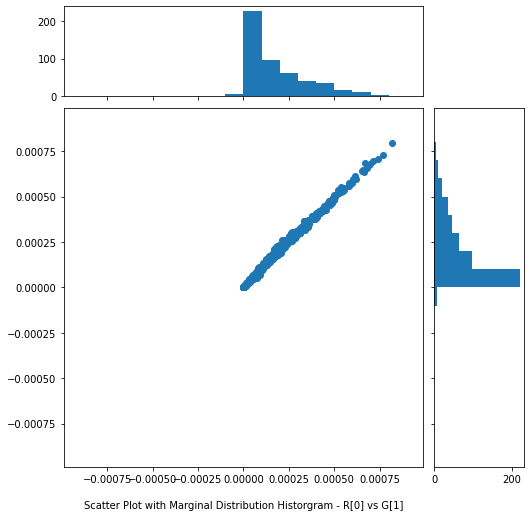

padding is: 9
KL Divergence: reset  tensor([[5.0724e-05, 5.4479e-05, 4.8757e-05]])
Mean: 0.000184983684448525309562683105
Variance: 0.000000033451954095653491094708
Standard Deviation: 0.000182898744242265820503234863


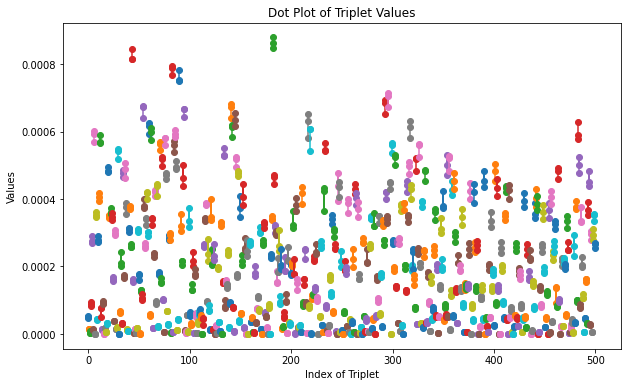

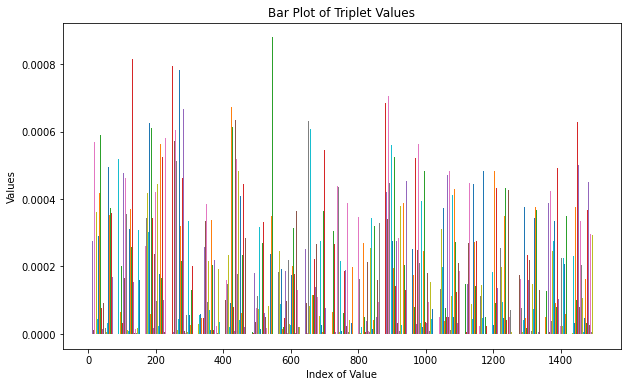

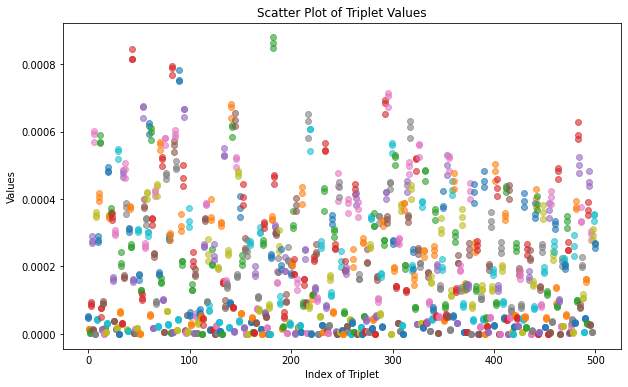

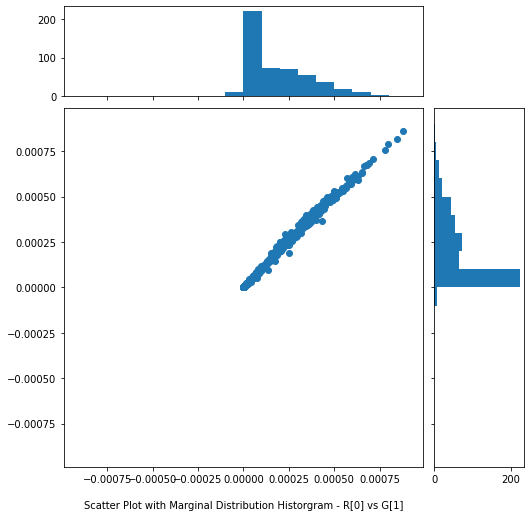

padding is: 10
KL Divergence: reset  tensor([[1.7226e-05, 1.6332e-05, 1.6391e-05]])
Mean: 0.000248564698267728090286254883
Variance: 0.000000058410638104078316246159
Standard Deviation: 0.000241682922933250665664672852


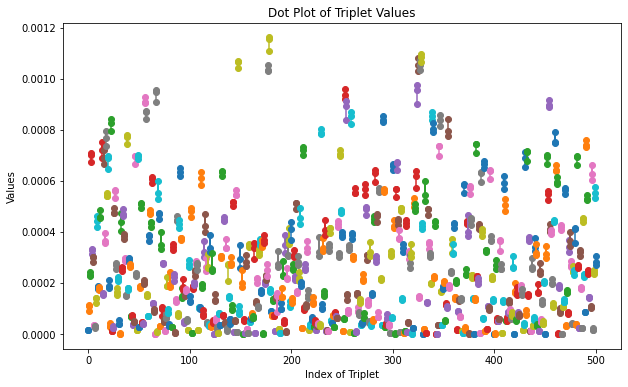

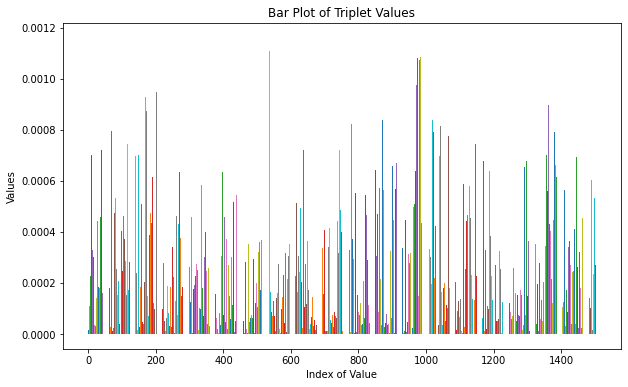

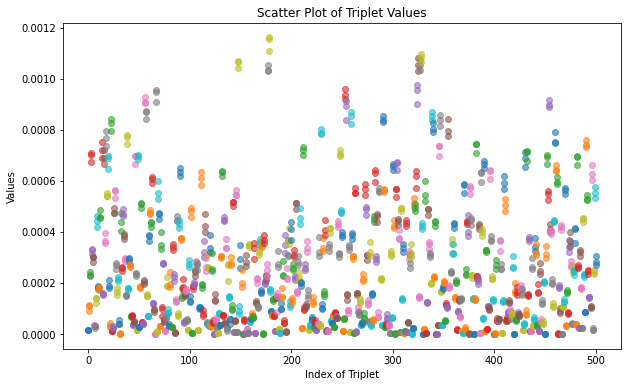

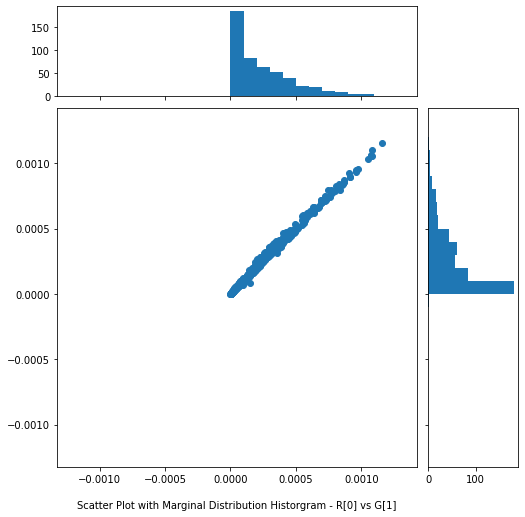

In [46]:
pad = 1
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 2
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 3
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 4
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 5
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 6
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 7
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 8
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 9
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 10
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")

padding is: 11
KL Divergence: reset  tensor([[0.0004, 0.0004, 0.0004]])
Mean: 0.000332053430611267685890197754
Variance: 0.000000100994398621878644917160
Standard Deviation: 0.000317796162562444806098937988


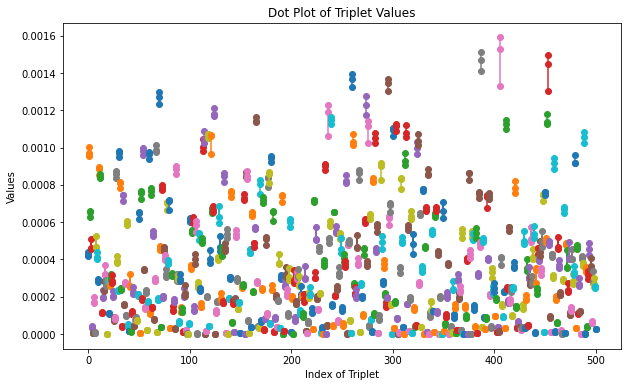

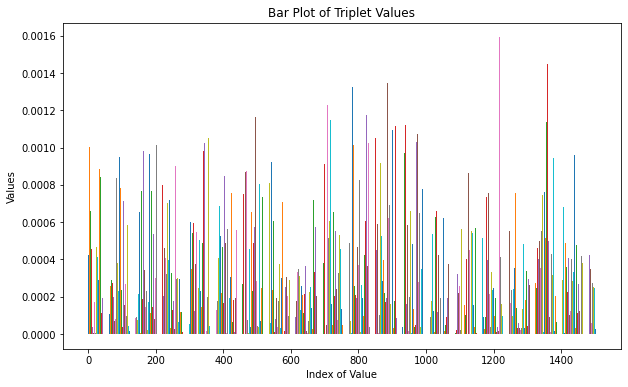

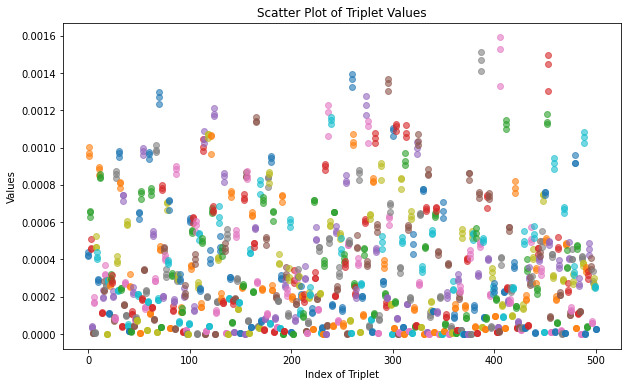

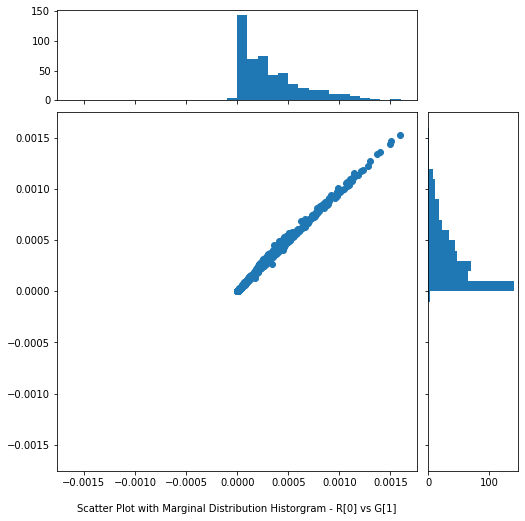

padding is: 12
KL Divergence: reset  tensor([[2.1517e-05, 2.0146e-05, 2.0325e-05]])
Mean: 0.000333334028255194425582885742
Variance: 0.000000138842878527611901517957
Standard Deviation: 0.000372616254026070237159729004


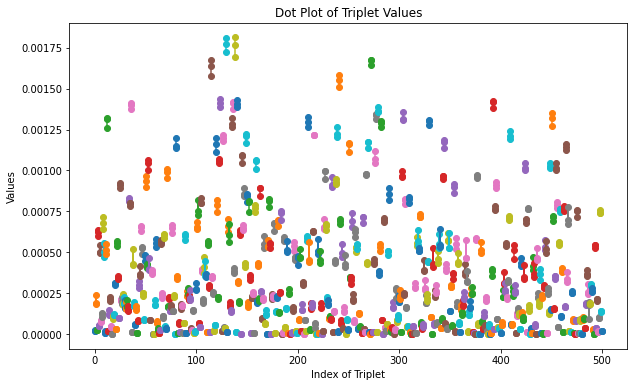

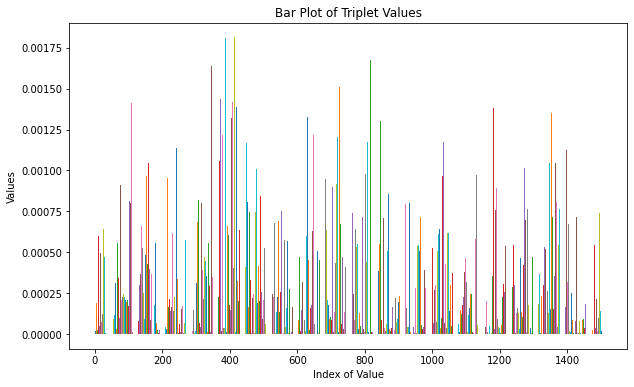

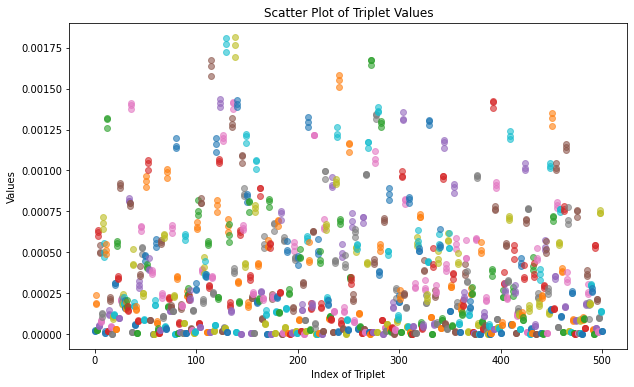

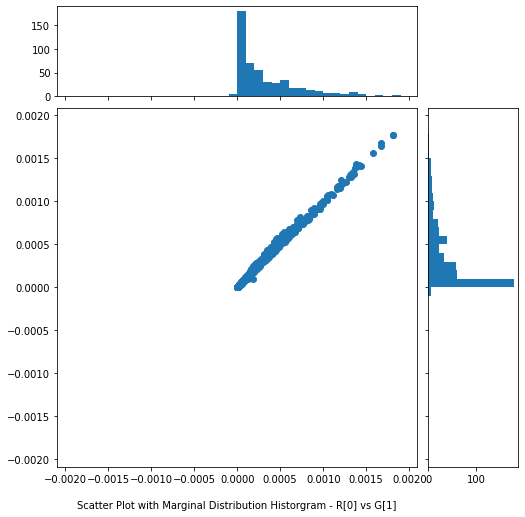

padding is: 13
KL Divergence: reset  tensor([[0.0016, 0.0016, 0.0015]])
Mean: 0.000379948905901983380317687988
Variance: 0.000000175394376356052816845477
Standard Deviation: 0.000418801122577860951423645020


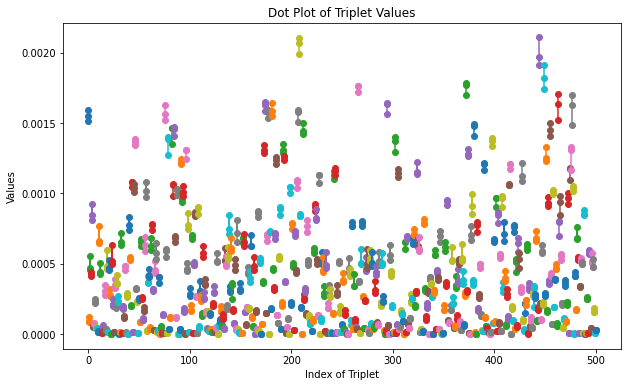

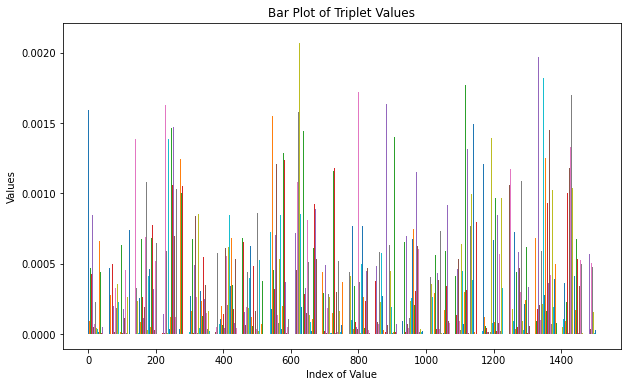

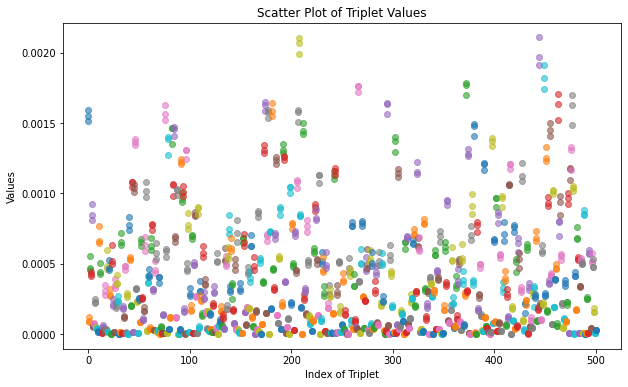

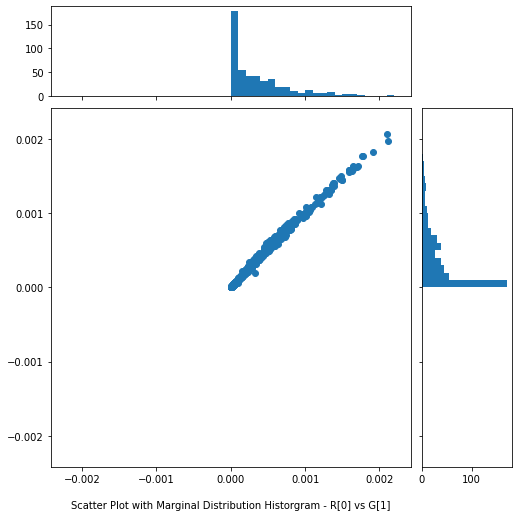

padding is: 14
KL Divergence: reset  tensor([[0.0003, 0.0004, 0.0003]])
Mean: 0.000519227935001254081726074219
Variance: 0.000000254935827115332358516753
Standard Deviation: 0.000504911702591925859451293945


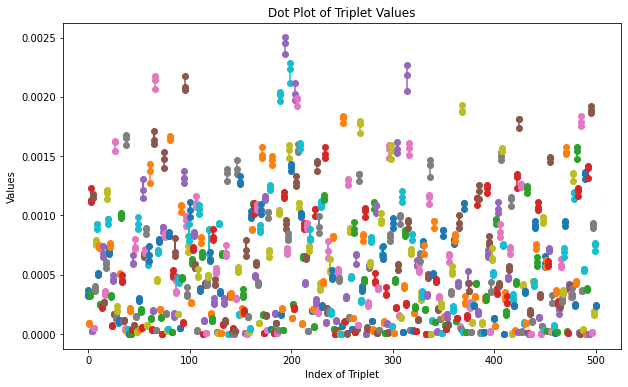

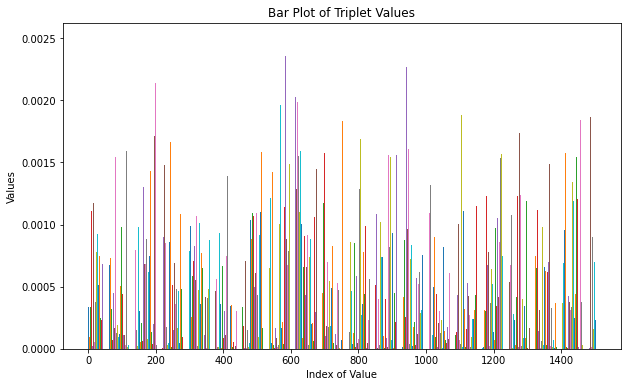

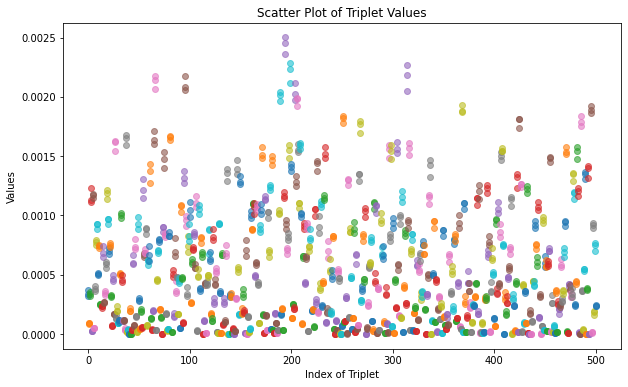

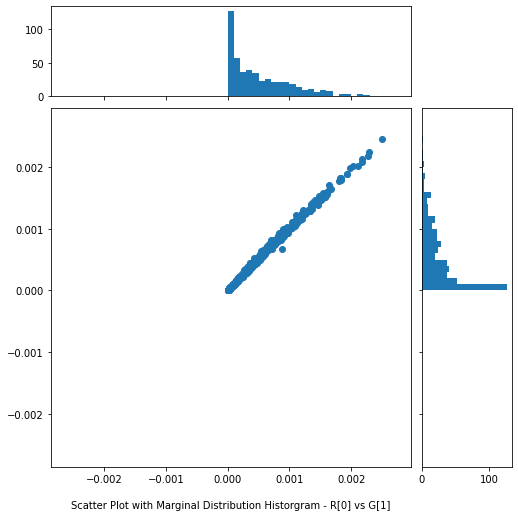

padding is: 15
KL Divergence: reset  tensor([[2.8014e-06, 7.2122e-06, 3.0994e-06]])
Mean: 0.000542579276952892541885375977
Variance: 0.000000300721097801215364597738
Standard Deviation: 0.000548380427062511444091796875


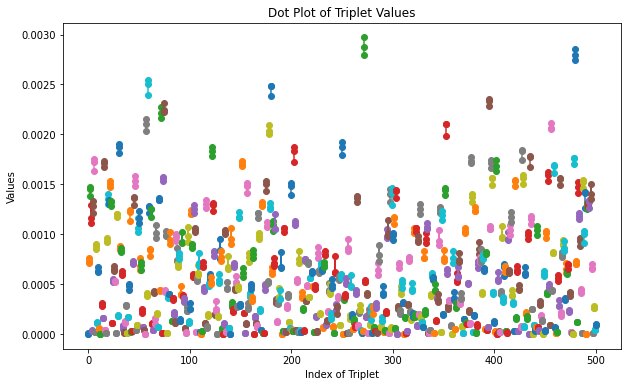

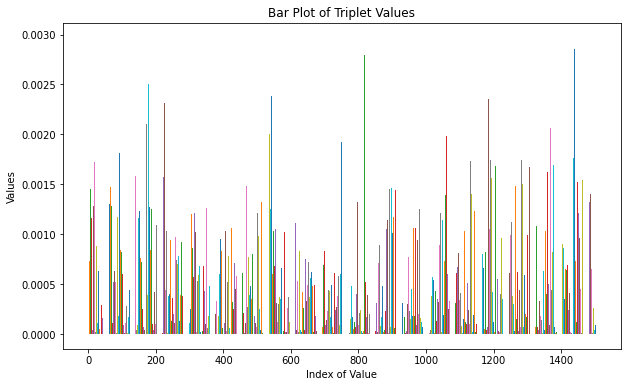

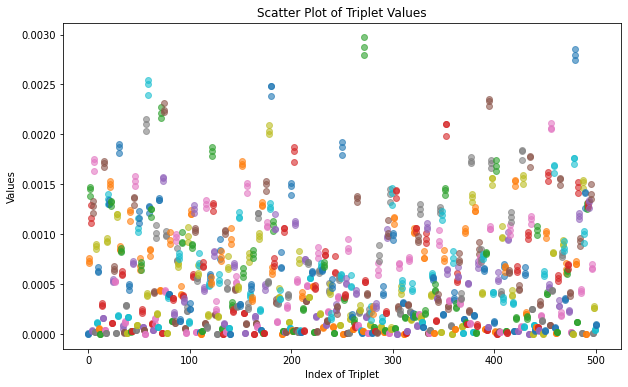

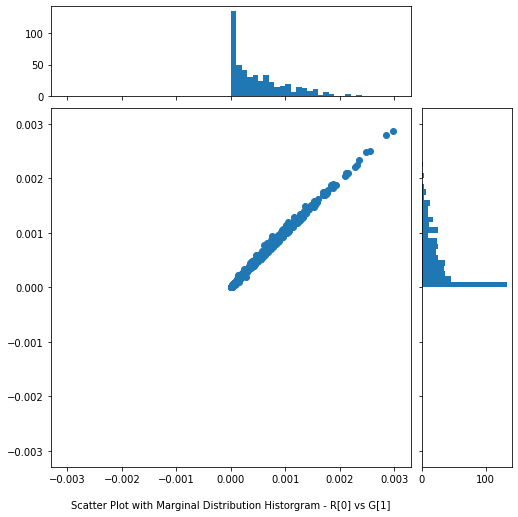

padding is: 16
KL Divergence: reset  tensor([[0.0005, 0.0005, 0.0005]])
Mean: 0.000544909562449902296066284180
Variance: 0.000000308522459135929238982499
Standard Deviation: 0.000555448001250624656677246094


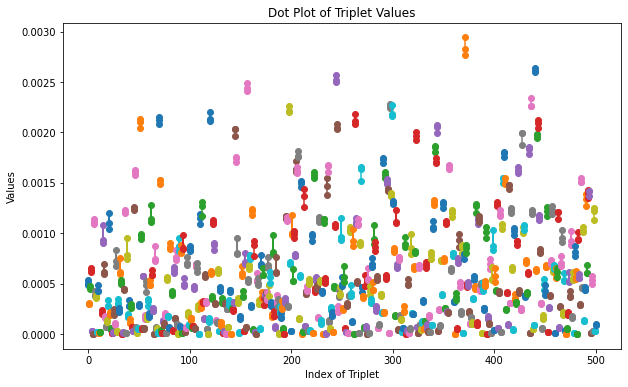

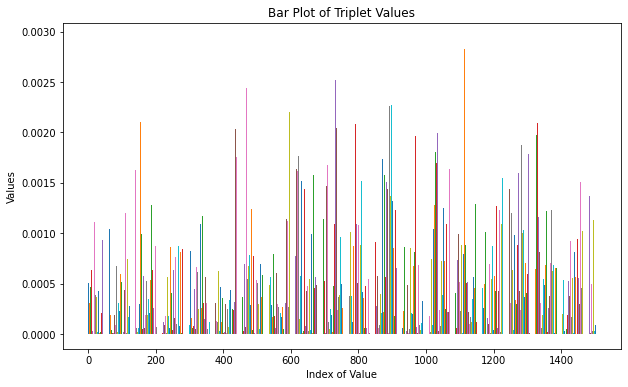

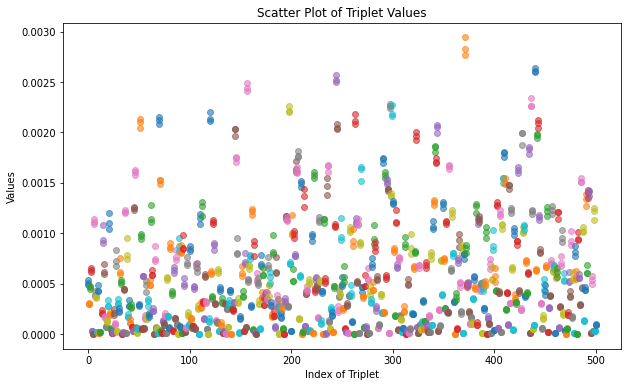

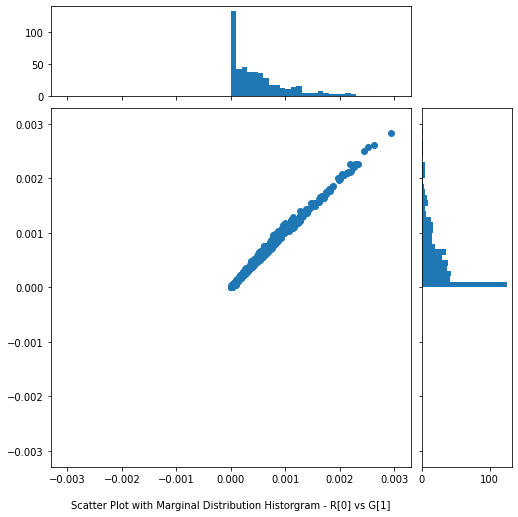

padding is: 17
KL Divergence: reset  tensor([[0.0023, 0.0024, 0.0022]])
Mean: 0.000713820802047848701477050781
Variance: 0.000000492076537739194463938475
Standard Deviation: 0.000701481651049107313156127930


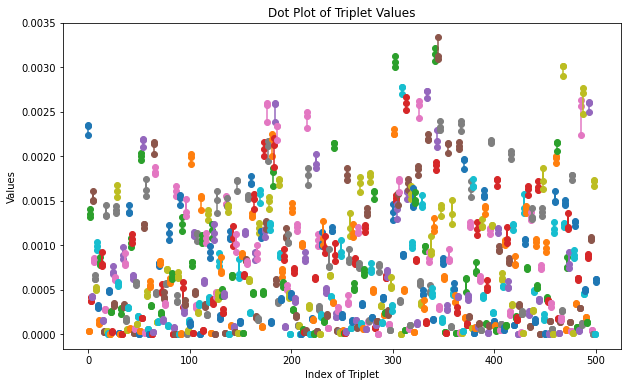

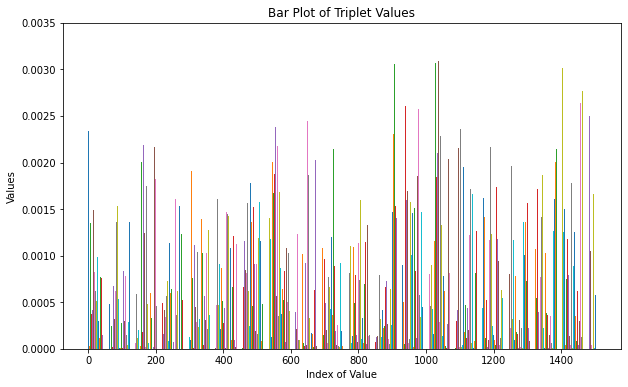

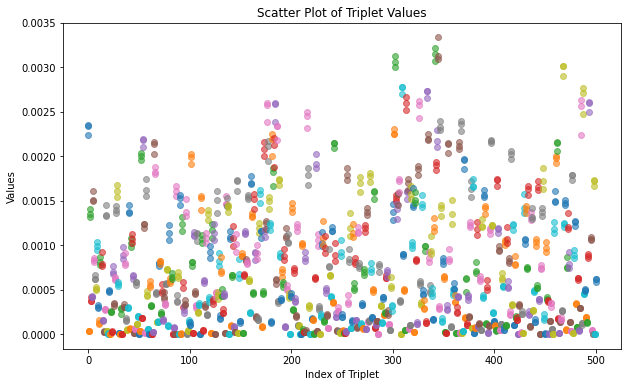

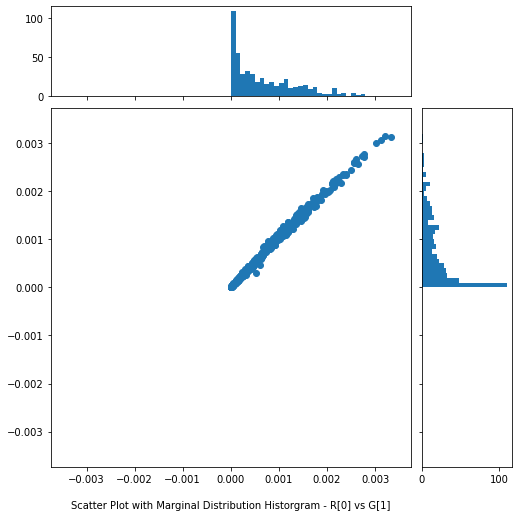

padding is: 18
KL Divergence: reset  tensor([[3.1412e-05, 3.2365e-05, 2.9624e-05]])
Mean: 0.000763852905947715044021606445
Variance: 0.000000620774414983316091820598
Standard Deviation: 0.000787892378866672515869140625


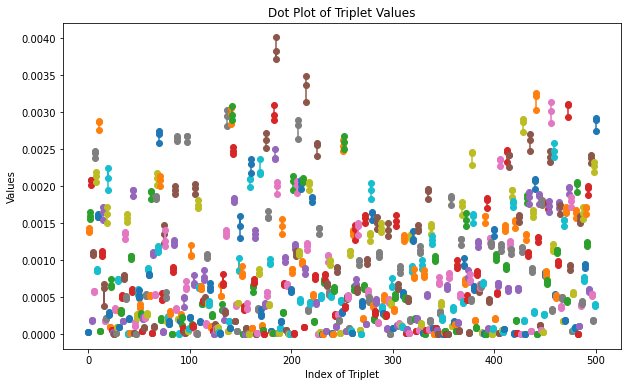

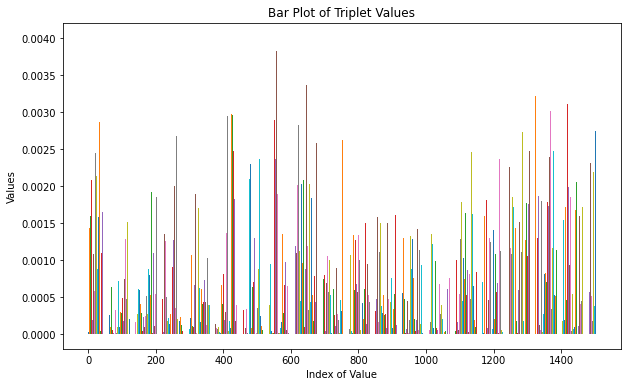

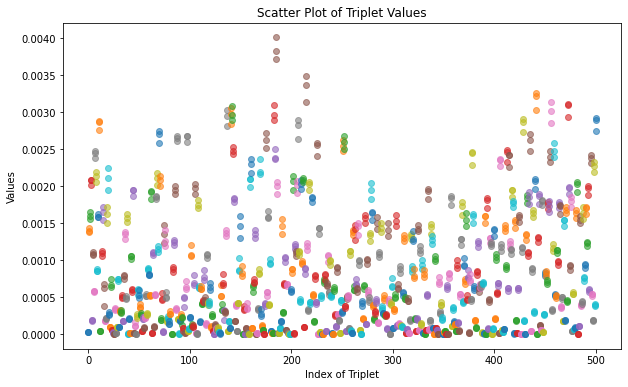

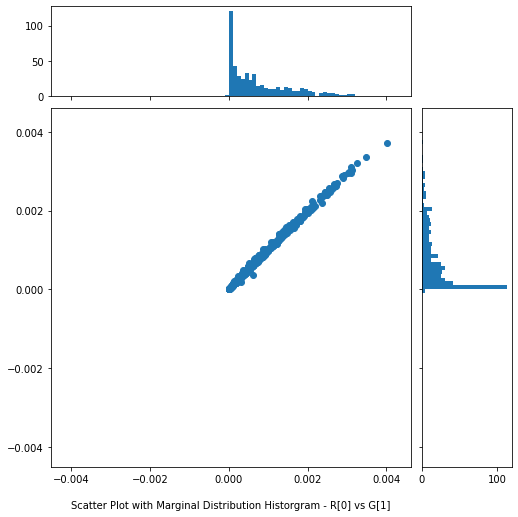

padding is: 19
KL Divergence: reset  tensor([[2.0266e-05, 2.5988e-05, 1.8835e-05]])
Mean: 0.000936808472033590078353881836
Variance: 0.000000842090457808808423578739
Standard Deviation: 0.000917654891964048147201538086


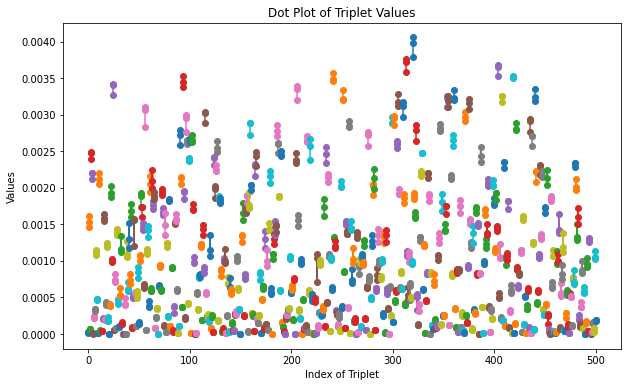

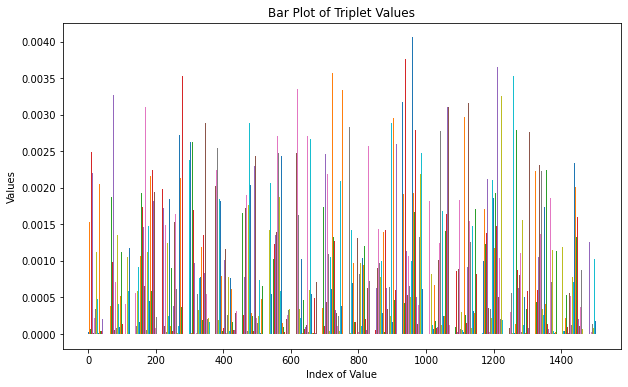

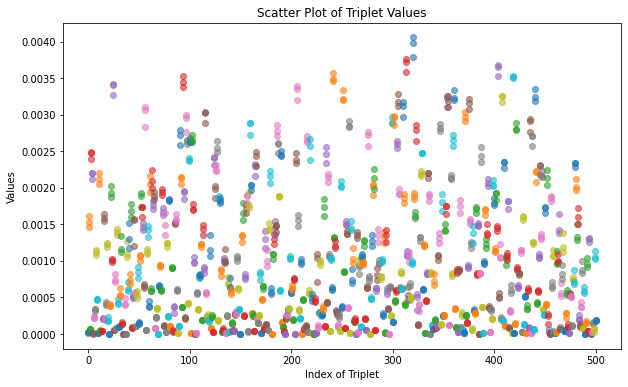

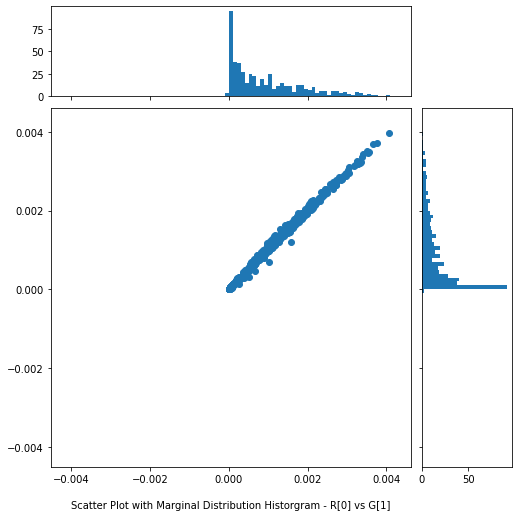

padding is: 20
KL Divergence: reset  tensor([[0.0032, 0.0032, 0.0030]])
Mean: 0.000845894217491149902343750000
Variance: 0.000000677920127145625883713365
Standard Deviation: 0.000823359063360840082168579102


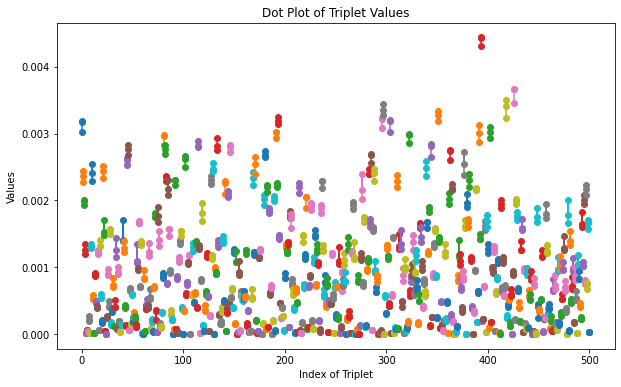

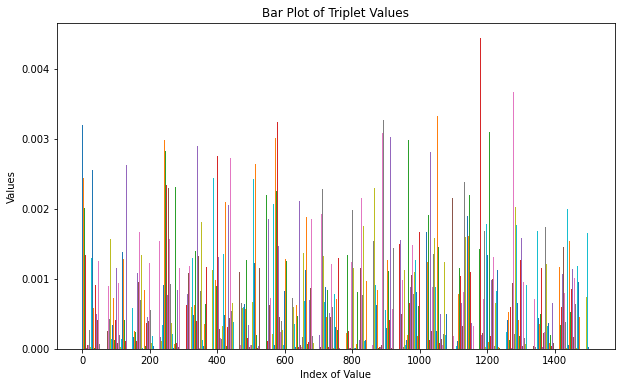

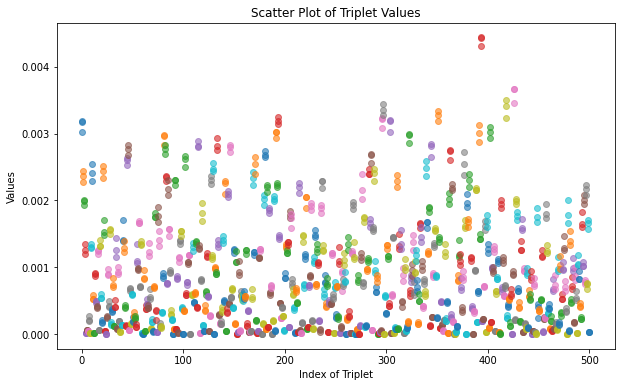

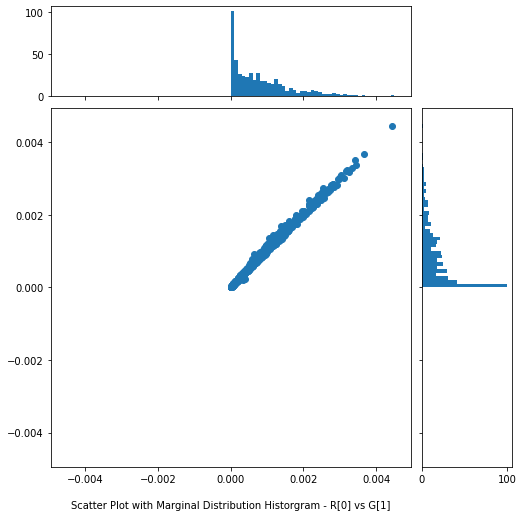

In [47]:
pad = 11
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 12
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 13
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 14
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 15
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 16
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 17
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 18
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 19
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")


pad = 20
print("padding is:", pad)
kl_metrics = collect_kl_metrics(env, max_timesteps, pad)
mu, var, std = calculate_statistics(kl_metrics)
stats.append((mu, var, std))
visualize_triplets_and_stats(kl_metrics)

flat_triplets = torch.cat(kl_metrics).numpy()
x1 = flat_triplets[::3]
x2 = flat_triplets[1::3]
x3 = flat_triplets[2::3]
scatter_hist_plotter(x1, x2, "R[0] vs G[1]")

crop val: 0
mean    : 8.44696579349602e-09    var: 4.513374295983953e-16    stddev: 2.1244703773959372e-08

crop val: 1
mean    : 4.3113827814522665e-06    var: 1.4260552808065263e-11    stddev: 3.776314770220779e-06

crop val: 2
mean    : 1.2622463145817164e-05    var: 1.6317974749213704e-10    stddev: 1.277418323297752e-05

crop val: 3
mean    : 2.8834014301537536e-05    var: 8.27380997048266e-10    stddev: 2.8764230592059903e-05

crop val: 4
mean    : 4.736897608381696e-05    var: 2.063821780140529e-09    stddev: 4.542930764728226e-05

crop val: 5
mean    : 7.157411164371297e-05    var: 5.44680656133778e-09    stddev: 7.380248280242085e-05

crop val: 6
mean    : 0.00010244398436043411    var: 1.1761122742370844e-08    stddev: 0.00010844870848814026

crop val: 7
mean    : 0.0001202530474984087    var: 1.569054042249718e-08    stddev: 0.0001252618822036311

crop val: 8
mean    : 0.00017341849161311984    var: 2.931457920851699e-08    stddev: 0.00017121501150541008

crop val: 9
mean   

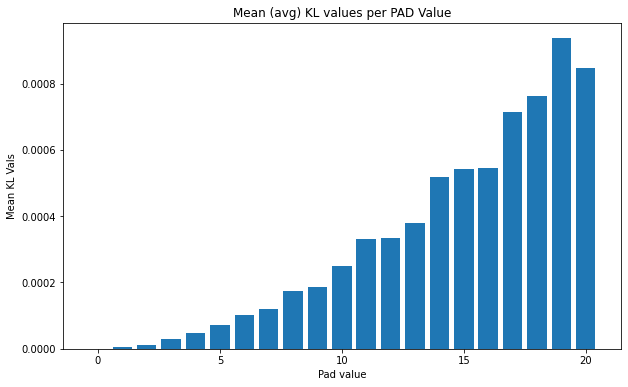

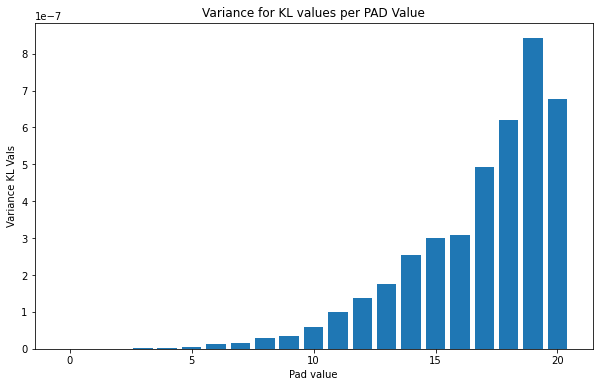

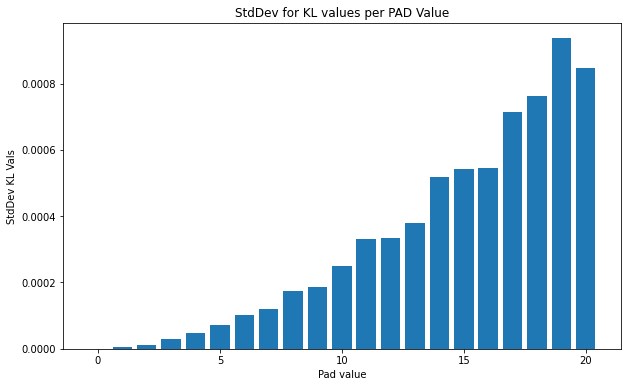

In [51]:
# print(stats)

for i in range(len(stats)):
    print('crop val:', i)
    print('mean    :', stats[i][0], '   var:', stats[i][1], '   stddev:', stats[i][2])
    print()

    
import matplotlib.pyplot as plt

def plot_bar(values, title, value_names):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(values)), values)
    plt.xlabel('Pad value')
    plt.ylabel(value_names)
    plt.title(title)
    plt.show()


mus = [i[0] for i in stats]
varz = [i[1] for i in stats]
stds = [i[2] for i in stats]

plot_bar(mus, 'Mean (avg) KL values per PAD Value', 'Mean KL Vals')

plot_bar(varz, 'Variance for KL values per PAD Value', 'Variance KL Vals')

plot_bar(mus, 'StdDev for KL values per PAD Value', 'StdDev KL Vals')
